In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0567

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 732ms/step - loss: 0.0454
Average validation loss: 0.6698212027549744
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 739ms/step - loss: 0.0454 - val_loss: 0.6698
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 804ms/step - loss: 0.0328 - val_loss: 0.6698
Average validation loss: 0.5407965779304504
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 822ms/step - loss: 0.0328 - val_loss: 0.6053
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 818ms/step - loss: 0.0252 - val_loss: 0.6053
Average validation loss: 0.4340006411075592
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 831ms/step - loss: 0.0252 - val_loss: 0.5482
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step - loss: 1.5648e-05
Average validation loss: 0.1051449216902256
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 817ms/step - loss: 1.5648e-05 - val_loss: 0.1051
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 818ms/step - loss: 1.5226e-05 - val_loss: 0.1051
Average validation loss: 0.07757194712758064
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 827ms/step - loss: 1.5226e-05 - val_loss: 0.0914
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 835ms/step - loss: 1.4975e-05 - val_loss: 0.0914
Average validation loss: 0.06459877826273441
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 844ms/step - loss: 1.4975e-05 - val_loss: 0.0824
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 829ms/step - loss: 4.1326e-06
Average validation loss: 0.016977776462833088
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - loss: 4.1326e-06 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 835ms/step - loss: 4.3137e-06 - val_loss: 0.0170
Average validation loss: 0.051379334181547165
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 843ms/step - loss: 4.3137e-06 - val_loss: 0.0342
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 825ms/step - loss: 4.1458e-06 - val_loss: 0.0342
Average validation loss: 0.05584445968270302
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 834ms/step - loss: 4.1458e-06 - val_loss: 0.0414
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - loss: 4.1293e-06 - val_loss: 0.0414
Average validation loss: 0.043761517852544785
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 833ms/step - loss: 4.1293e-06 - val_loss: 0.0420
Epoch 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 819ms/step - loss: 3.3102e-06
Average validation loss: 0.01624583196826279
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 830ms/step - loss: 3.3102e-06 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 804ms/step - loss: 2.9320e-06 - val_loss: 0.0162
Average validation loss: 0.0096525305416435
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 815ms/step - loss: 2.9320e-06 - val_loss: 0.0129
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 808ms/step - loss: 2.9157e-06 - val_loss: 0.0129
Average validation loss: 0.010269844671711326
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 818ms/step - loss: 2.9157e-06 - val_loss: 0.0121
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 796ms/step - loss: 2.8010e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 942ms/step - loss: 2.3202e-06
Average validation loss: 0.009282331774011254
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step - loss: 2.3202e-06 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 802ms/step - loss: 2.0169e-06 - val_loss: 0.0093
Average validation loss: 0.00625476841814816
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 811ms/step - loss: 2.0169e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 778ms/step - loss: 1.8358e-06 - val_loss: 0.0078
Average validation loss: 0.014897013362497092
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 789ms/step - loss: 1.8358e-06 - val_loss: 0.0101
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 790ms/step - loss: 1.630

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 788ms/step - loss: 1.5089e-06
Average validation loss: 0.01235876806701223
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 800ms/step - loss: 1.5089e-06 - val_loss: 0.0124
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 777ms/step - loss: 1.2084e-06 - val_loss: 0.0124
Average validation loss: 0.005376246563779811
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 789ms/step - loss: 1.2084e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 782ms/step - loss: 1.0168e-06 - val_loss: 0.0089
Average validation loss: 0.008472917329830429
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 796ms/step - loss: 1.0168e-06 - val_loss: 0.0087
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 772ms/step - loss: 9.165

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 775ms/step - loss: 3.1987e-06
Average validation loss: 0.06216679932549596
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 787ms/step - loss: 3.1987e-06 - val_loss: 0.0622
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 774ms/step - loss: 2.4584e-06 - val_loss: 0.0622
Average validation loss: 0.05341402147896588
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 2.4584e-06 - val_loss: 0.0578
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 776ms/step - loss: 2.0742e-06 - val_loss: 0.0578
Average validation loss: 0.021417603734880684
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 789ms/step - loss: 2.0742e-06 - val_loss: 0.0457
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\we

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 776ms/step - loss: 1.7494e-05
Average validation loss: 0.13630042970180511
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 786ms/step - loss: 1.7494e-05 - val_loss: 0.1363
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 794ms/step - loss: 1.5486e-05 - val_loss: 0.1363
Average validation loss: 0.09751084074378014
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 805ms/step - loss: 1.5486e-05 - val_loss: 0.1169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 782ms/step - loss: 1.3890e-05 - val_loss: 0.1169
Average validation loss: 0.10651600733399391
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 793ms/step - loss: 1.3890e-05 - val_loss: 0.1134
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 775ms/step - loss: 1.30

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 764ms/step - loss: 2.8588e-06
Average validation loss: 0.03262361488305032
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 776ms/step - loss: 2.8588e-06 - val_loss: 0.0326
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 848ms/step - loss: 2.2886e-06 - val_loss: 0.0326
Average validation loss: 0.01242280872871301
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 859ms/step - loss: 2.2886e-06 - val_loss: 0.0225
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 811ms/step - loss: 1.8561e-06 - val_loss: 0.0225
Average validation loss: 0.01041255660155522
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 823ms/step - loss: 1.8561e-06 - val_loss: 0.0185
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 781ms/step - loss: 1.2280e-06
Average validation loss: 0.01280391842010431
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 792ms/step - loss: 1.2280e-06 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 783ms/step - loss: 9.1084e-07 - val_loss: 0.0128
Average validation loss: 0.051307991961948574
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 794ms/step - loss: 9.1084e-07 - val_loss: 0.0321
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 806ms/step - loss: 1.0690e-06 - val_loss: 0.0321
Average validation loss: 0.011061064171371982
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 817ms/step - loss: 1.0690e-06 - val_loss: 0.0251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 783ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 1.2284e-06
Average validation loss: 0.01950316545036104
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 1.2284e-06 - val_loss: 0.0195
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 8.7359e-07 - val_loss: 0.0195
Average validation loss: 0.010739538430546721
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 793ms/step - loss: 8.7359e-07 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 783ms/step - loss: 6.9797e-07 - val_loss: 0.0151
Average validation loss: 0.009872962668952014
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 794ms/step - loss: 6.9797e-07 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 775ms/step - loss: 4.9732e-07
Average validation loss: 0.007987799413967878
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 4.9732e-07 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 866ms/step - loss: 4.3079e-07 - val_loss: 0.0080
Average validation loss: 0.00870598021429032
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 877ms/step - loss: 4.3079e-07 - val_loss: 0.0083
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 809ms/step - loss: 4.2136e-07 - val_loss: 0.0083
Average validation loss: 0.022617653803899886
80/80 ━━━━━━━━━━━━━━━━━━━━ 199s 820ms/step - loss: 4.2136e-07 - val_loss: 0.0131
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 262s 788ms/step - loss: 3.8551e-07 - val_loss: 0.0131
Average validation loss: 0.007943215488921851
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 799ms/step - loss: 3.8551e-07 - val_loss: 0.0118

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 780ms/step - loss: 8.1398e-06
Average validation loss: 0.3551993432144324
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 791ms/step - loss: 8.1398e-06 - val_loss: 0.3552
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 768ms/step - loss: 5.7930e-06 - val_loss: 0.3552
Average validation loss: 0.02483120351098478
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 778ms/step - loss: 5.7930e-06 - val_loss: 0.1900
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 775ms/step - loss: 4.2179e-06 - val_loss: 0.1900
Average validation loss: 0.026135514412696164
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 786ms/step - loss: 4.2179e-06 - val_loss: 0.1354
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 301s 775ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 3.1176e-06
Average validation loss: 0.01710387513837001
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 3.1176e-06 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 789ms/step - loss: 2.6451e-06 - val_loss: 0.0171
Average validation loss: 0.010125423253824314
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 800ms/step - loss: 2.6451e-06 - val_loss: 0.0136
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 793ms/step - loss: 2.0441e-06 - val_loss: 0.0136
Average validation loss: 0.008510376520765325
120/120 ━━━━━━━━━━━━━━━━━━━━ 288s 804ms/step - loss: 2.0441e-06 - val_loss: 0.0119
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 781ms/step - loss: 2.1941e-06
Average validation loss: 0.014184018244527074
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 2.1941e-06 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 228s 787ms/step - loss: 1.6277e-06 - val_loss: 0.0142
Average validation loss: 0.010632874356815591
144/144 ━━━━━━━━━━━━━━━━━━━━ 229s 798ms/step - loss: 1.6277e-06 - val_loss: 0.0124
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 784ms/step - loss: 1.9035e-06 - val_loss: 0.0124
Average validation loss: 0.01806228098252581
144/144 ━━━━━━━━━━━━━━━━━━━━ 343s 794ms/step - loss: 1.9035e-06 - val_loss: 0.0143
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 455s 7

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 778ms/step - loss: 1.7199e-06
Average validation loss: 0.009455377799167764
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 789ms/step - loss: 1.7199e-06 - val_loss: 0.0095
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 776ms/step - loss: 1.2914e-06 - val_loss: 0.0095
Average validation loss: 0.03583280653529615
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 787ms/step - loss: 1.2914e-06 - val_loss: 0.0226
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 778ms/step - loss: 1.0309e-06 - val_loss: 0.0226
Average validation loss: 0.011919842986389994
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 788ms/step - loss: 1.0309e-06 - val_loss: 0.0191
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 504s 786ms/step - loss: 8.8206e-07 - val_loss: 0.0191
Average validation loss: 0.010393250657944008
160/160 ━━━━━━━━━━━━━━━━━━━━ 506s 796ms/step - loss: 8.8206e-07 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 781ms/step - loss: 1.7152e-06
Average validation loss: 0.07940465193241834
200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 792ms/step - loss: 1.7152e-06 - val_loss: 0.0794
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 781ms/step - loss: 1.3568e-06 - val_loss: 0.0794
Average validation loss: 0.044091190482654384
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 792ms/step - loss: 1.3568e-06 - val_loss: 0.0617
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 480s 815ms/step - loss: 1.1458e-06 - val_loss: 0.0617
Average validation loss: 0.01048675559781259
200/200 ━━━━━━━━━━━━━━━━━━━━ 482s 826ms/step - loss: 1.1458e-06 - val_loss: 0.0447
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 773ms/step - loss: 1.4324e-06
Average validation loss: 0.010839462824030003
240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 784ms/step - loss: 1.4324e-06 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 773ms/step - loss: 1.0313e-06 - val_loss: 0.0108
Average validation loss: 0.011039312188070955
240/240 ━━━━━━━━━━━━━━━━━━━━ 376s 783ms/step - loss: 1.0313e-06 - val_loss: 0.0109
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 778ms/step - loss: 8.3868e-07 - val_loss: 0.0109
Average validation loss: 0.011962772484957895
240/240 ━━━━━━━━━━━━━━━━━━━━ 565s 788ms/step - loss: 8.3868e-07 - val_loss: 0.0113
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 752s 779ms/step - loss: 7.4381e-07 - val_loss: 0.0113
Average validation loss: 0.011663988266188122
240/240 ━━━━━━━━━━━━━━━━━━━━ 755s 790ms/step - loss: 7.4381e-07

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.127317114174366, 0.07013941390439868, 0.025769445402547712, 0.022295338513795285, 0.01681819889927283, 0.008571759736320626, 0.05595038293558173, 0.0293455157855836, 0.030631133087112437, 0.02674347080901498, 0.016738194330181512, 0.010137022469425574, 0.022064048027386887, 0.01598023576471725, 0.03680971452284564, 0.027437095353353882, 0.01618527361313111, 0.01274990252416915]
std_val_losses =  [0.13591647467813278, 0.06498976479588464, 0.01933407725731332, 0.03383380756541426, 0.031174020843250383, 0.005415861769825597, 0.08090202747018457, 0.02616619035444471, 0.020644359244030113, 0.029608881154883457, 0.027658474460030884, 0.0044620780065574685, 0.04951018288101563, 0.011443402558207466, 0.03611725178444487, 0.029062671987088423, 0.012464004100303834, 0.005193487655493313]


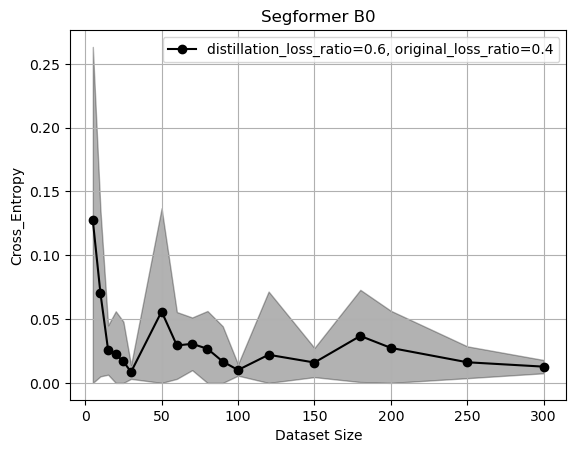

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()